**第8章**

In [1]:
# Sabrカリブレーション
from myABBR import * ; from scipy.optimize import minimize
# 市場データ
STKs = nA([0.06,   0.31, 0.56,  0.81,  1.06,  1.56,  2.56])/100
mVol = nA([90.78, 46.09, 45.3, 50.17, 53.85, 58.42, 62.72])/100
# パラメータ準備
fwdRT,   YR, beta, PRMs,                    BNDs                      =\
0.0056, 2.0, 0.5,  [0.1]*3, [(0.0001,None),(0,None),(-0.9999,0.9999)] 
                      # PRMs=[  alpha,       volvol,       rho ]
# 目的関数
def calcRMSE(PRMs):
    vols = [ql.sabrVolatility(ss, fwdRT, YR, 
                        PRMs[0], beta, PRMs[1], PRMs[2]) for ss in STKs]
    return ((nA(vols) - nA(mVol))**2 ).mean()**.5
# カリブレーション
RSLT = minimize(calcRMSE, PRMs, method='Powell', bounds=BNDs)
print(RSLT,'\n') ; print('(alpha,volvol,rho):', RSLT.x)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.013880599002214078
       x: [ 3.059e-02  7.282e-01  4.494e-01]
     nit: 5
   direc: [[-5.231e-03  1.449e-01 -3.919e-02]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.278e-05  1.443e-03  4.981e-03]]
    nfev: 198 

(alpha,volvol,rho): [0.03059 0.72824 0.44936]


calc Vols:  [0.89701 0.48497 0.44908 0.48925 0.52792 0.58327 0.64643]


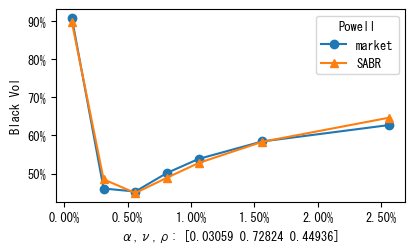

In [2]:
# ボラティリティ計算
cVol = [ql.sabrVolatility(ss, fwdRT, YR, 
                  RSLT.x[0], beta, RSLT.x[1], RSLT.x[2]) for ss in STKs]
print('calc Vols: ', nA(cVol))
# SABRグラフ
fig, ax = plt.subplots()
ax.plot(STKs, mVol, marker='o', label='market')
ax.plot(STKs, cVol, marker='^', label='SABR')
ax.set_ylabel('Black Vol'); ax.set_xlabel('α,ν,ρ: '+str(RSLT.x))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.legend(title='Powell') ; plt.show();

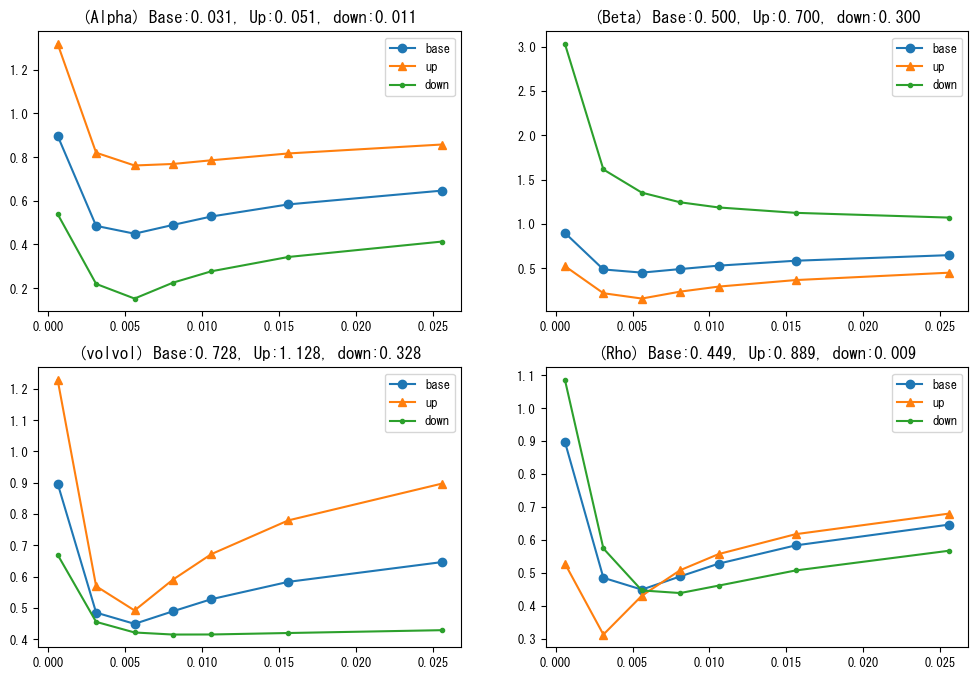

In [3]:
# SABR 4つのパラメータ
plt.rcParams.update({"figure.figsize":[12,8]}) ; fig,ax = plt.subplots(2,2)
# グラフ描写の関数
def drawGraph(xx, yy, ii):
    # ボラ計算
    cVol = [ql.sabrVolatility(ss, fwdRT, YR, *rslt4 ) for ss in STKs]
    uVol = [ql.sabrVolatility(ss, fwdRT, YR, *prmUP ) for ss in STKs]
    dVol = [ql.sabrVolatility(ss, fwdRT, YR, *prmDW ) for ss in STKs]
    # (xx, yy)でグラフの位置  iiはnamePRMリスト中の位置
    ax[xx,yy].plot(STKs, cVol, marker='o', label="base")
    ax[xx,yy].plot(STKs, uVol, marker='^', label="up"  )
    ax[xx,yy].plot(STKs, dVol, marker='.', label="down")
    ax[xx,yy].legend()
    ax[xx,yy].set_title('({}) Base:{:.3f}, Up:{:.3f}, down:{:.3f}'.format(
              namePRM[ii], rslt4[ii], prmUP[ii], prmDW[ii]),fontsize=12) 
# シフト幅の設定
rslt4 = np.insert(RSLT.x, 1, beta)        # RSLT.xにbetaを追加
namePRM = ['Alpha','Beta','volvol','Rho']
sftPRM  = [  0.02 , 0.2  ,  0.4   , 0.44]
for ii in range(4):                       # rslt4.copy()は値渡しでの複製
    prmUP  = rslt4.copy() ; prmUP[ii] += sftPRM[ii]
    prmDW  = rslt4.copy() ; prmDW[ii] -= sftPRM[ii]
    xx,yy = divmod(ii, 2) ; drawGraph(xx,yy,ii)
plt.rcParams.update({"figure.figsize":[4.5,2.5]})    #figsizeのリセット

In [4]:
# ノーマルボラティリティ近似式 Hagan(2002) B.69a
def normalVol(K, F, TT, beta, alpha, volvol, rho):
    eps = 1e-7                                 # Numerical tolerance
    A1 = 1+np.log(F/K)**2/24+np.log(F/K)**4/1920
    A2 = 1+((1-beta)**2)/24*np.log(F/K)**2 + ((1-beta)**4)/1920*np.log(F/K)**4
    AA = alpha*(F*K)**(beta/2)*A1/A2

    ZZ = (volvol/alpha)*(F*K)**((1-beta)/2) * np.log(F/K)
    XX = np.log(((1-2*rho*ZZ+ZZ**2)**.5 -rho+ZZ)/(1-rho))
    BB = ZZ/XX if abs(ZZ)>eps else 1.     # BB goes to 1 when ZZ is 0

    C1 = -beta*(2-beta)*alpha**2 / (24*(F*K)**(1-beta))
    C2 = rho*alpha*volvol*beta / (4*(F*K)**((1-beta)/2))
    C3 = (2-3*rho**2)*volvol**2 / 24
    CC = 1+(C1+C2+C3)*TT
    return AA*BB*CC

In [5]:
# 2.5% Shifted SABR ノーマルボラ近似関数
def shtNormalVol(K, F, TT, beta, alpha, volvol, rho):
    SS = 2.5/100
    return normalVol(K+SS, F+SS, TT, beta, alpha, volvol, rho)

In [6]:
# Shifted Sabrカリブレーション
from myABBR import * ; from scipy.optimize import minimize
# 市場データ(EuroSwaption 2Yx5Y)
STKs=nA([-0.95, -0.45, -0.20, 0.05,  0.30,  0.55,  1.05])/100
mVol=nA([41.94, 38.64, 37.71, 37.8, 39.05, 41.37, 47.81])/10000

# パラメータ準備
fwdRT,  YR, beta,  PRMs,           BNDs,                            mtd     =\
0.0005, 2.0, 0.5, [0.1]*3,[(0.001,None),(0,None),(-0.999,0.999)],'L-BFGS-B'
                   # PRMs=[    alpha,      volvol,      rho ]
# 目的関数
def calcRMSE(PRMs):
    vols = [shtNormalVol(ss, fwdRT, YR, beta, *PRMs) for ss in STKs]
    return ((nA(vols) - nA(mVol))**2 ).mean()**.5
# カリブレーション
RSLT = minimize(calcRMSE, PRMs, method=mtd, bounds=BNDs) 
#                                             ,tol=1e-8)#,options={'maxiter':1})
print(RSLT,'\n') ; print(mtd+'(alpha,volvol,rho):', RSLT.x)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.6025904665006075e-06
        x: [ 2.289e-02  4.631e-01 -3.205e-02]
      nit: 30
      jac: [ 1.793e-05  4.036e-06 -8.702e-06]
     nfev: 168
     njev: 42
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64> 

L-BFGS-B(alpha,volvol,rho): [ 0.02289  0.46314 -0.03205]


calc Vols:  [0.0042  0.00386 0.00377 0.00378 0.00391 0.00414 0.00477]


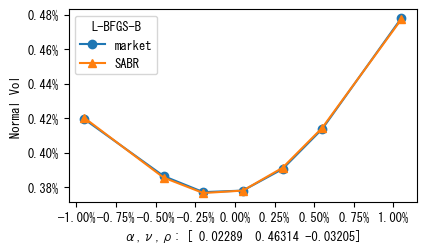

In [7]:
# ボラティリティ計算
cVol = [shtNormalVol(ss, fwdRT, YR, beta, *RSLT.x ) for ss in STKs]
print('calc Vols: ', nA(cVol))
# SABRグラフ
fig, ax = plt.subplots()
ax.plot(STKs, mVol, marker='o', label='market')
ax.plot(STKs, cVol, marker='^', label='SABR')
ax.set_ylabel('Normal Vol'); ax.set_xlabel('α,ν,ρ: '+str(RSLT.x))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,2))
ax.legend(title=mtd) ; plt.show();

In [8]:
#check OTM
print(f'-1.95% K:vol={shtNormalVol(-0.0195,fwdRT,YR,beta,*RSLT.x):.4%}',end=', ')
print(f' 2.05% K:vol={shtNormalVol( 0.0205,fwdRT,YR,beta,*RSLT.x):.4%}')

-1.95% K:vol=0.4888%,  2.05% K:vol=0.6229%


In [9]:
# パラメータ準備, 数値微分用関数インポート 
fwdRT,  YR, beta,  PRMs,           BNDs,                         =\
0.0005, 2.0, 0.5, [0.1]*3,[(0.001,None),(0,None),(-0.999,0.999)]

mtd,      jacHist                                                =\
'L-BFGS-B', []     ;from scipy.optimize import approx_fprime

# 目的関数
def calcRMSE(PRMs):
    vols = [shtNormalVol(ss, fwdRT, YR, beta, *PRMs) for ss in STKs]
    return ((nA(vols) - nA(mVol))**2 ).mean()**.5
# 数値微分とjac履歴保存
def jacFUN(PRMs): return approx_fprime(PRMs, calcRMSE, epsilon=1e-8)
def cBack(PRMs):  jacHist.append(jacFUN(PRMs))
# カリブレーション
RSLT = minimize(calcRMSE, PRMs, method=mtd, bounds=BNDs,
                                         jac=jacFUN, callback=cBack)
print(RSLT,'\n')      ; print('jacHistory: First3', '-'*10)
print(nA(jacHist)[:3]); print('Last5', '-'*23) ; print(nA(jacHist)[-5:])

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.6025904665006075e-06
        x: [ 2.289e-02  4.631e-01 -3.205e-02]
      nit: 30
      jac: [ 1.793e-05  4.036e-06 -8.702e-06]
     nfev: 42
     njev: 42
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64> 

jacHistory: First3 ----------
[[-0.00714 -0.00025  0.0001 ]
 [-0.00003 -0.00023  0.0001 ]
 [ 0.00018 -0.00023  0.0001 ]]
Last5 -----------------------
[[-0.02435 -0.00023  0.00002]
 [ 0.01577  0.00013  0.00008]
 [ 0.00154  0.00007 -0.00004]
 [ 0.00208  0.00003 -0.     ]
 [ 0.00002  0.      -0.00001]]
